<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:170%;
            text-align:center;
            border-radius:15px;
            background-color:#419E61;
            overflow:hidden;
            font-weight:700;">
    Green Defend
    <div style="font-size:70%; font-weight:500; margin-top:5px;">
        Intelligent Plant Disease Detection and Agriculyure Support System
    </div>
</div>

<style>
    .jp-InputArea-editor {
        display: none;
    }
</style>


<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:120%;
            text-align:left;
            border-radius:15px;
            overflow:hidden;
            font-weight:700;
            background-color:#333;">
            About NoteBook
</div>

The goal of this project is to identify 38 different plant diseases from RGB images of crop leaves. By leveraging deep learning techniques, this model helps in detecting and categorizing diseases, aiding farmers and agricultural experts.


<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:120%;
            text-align:left;
            border-radius:15px;
            overflow:hidden;
            font-weight:700;
            background-color:#333;">
            About DataSet
</div>


> * This dataset is recreated using offline augmentation from the original dataset.
> * This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. 
> * The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structurs
> *  A new directory containing 33 test images is created later for prediction purpose.e.

## Import libraries

In [31]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D

from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [33]:
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

test_dir  ="/kaggle/input/new-plant-diseases-dataset/test/test"

In [34]:
image_shape = (224,224)
batch_size = 64

In [35]:
# apply scaling only becouse data already augmented

train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

## Load training, Validation and Testing data

### Training data


In [36]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

Found 56251 images belonging to 38 classes.


### Validation data (20% of training data)


In [37]:
valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

Found 14044 images belonging to 38 classes.


### Test data (consider validation data as test data)


In [38]:
test_data = test_datagen.flow_from_directory(valid_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Found 17572 images belonging to 38 classes.


***From previous cell we know that we have 38 class***
> * 56251 images in train data
> * 14044 images in valisation data
> * 17572 images in test datata

### What are 38 classes are?

In [39]:
# show how data store 
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')
print(f'label  \n{labels[0]}')

shape of image is : (224, 224, 3)
label  
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [40]:
# show all diseases in dataset
diseases = os.listdir(train_dir)
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

***We notice that we have the same plant in different class such as:***
 > * Tomato___Early_blight
 > * Tomato___Late_blight
 > * Tomato___healthy
 > * ...

***so we need to know what is the different type of plant we have***

In [41]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :14
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [42]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Late_blight                                         1851
Tomato___healthy                                             1926
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Potato___healthy                                             1824
Corn_(maize)___Northern_Leaf_Blight                          1908
Tomato___Early_blight                                        1920
Tomato___Septoria_leaf_spot                                  1745
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Strawberry___Leaf_scorch                                     1774
Peach___healthy                                              1728
Apple___Apple_scab                                           2016
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Tomato___Bacterial_spot                                      1702
Apple___Black_rot                                            1987
Blueberry___healthy                                          1816
Cherry_(including_sour)___Powdery_mildew                     1683
Peach___Bacterial_spot                                       1838
Apple___Cedar_apple_rust                                     1760
Tomato___Target_Spot                                         1827
Pepper,_bell___healthy                                       1988
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Potato___Late_blight                                         1939
Tomato___Tomato_mosaic_virus                                 1790
Strawberry___healthy                                         1824
Apple___healthy                                              2008
Grape___Black_rot                                            1888
Potato___Early_blight                                        1939
Cherry_(including_sour)___healthy                            1826
Corn_(maize)___Common_rust_                                  1907
Grape___Esca_(Black_Measles)                                 1920
Raspberry___healthy                                          1781
Tomato___Leaf_Mold                                           1882
Tomato___Spider_mites Two-spotted_spider_mite                1741
Pepper,_bell___Bacterial_spot                                1913
Corn_(maize)___healthy                                       1859

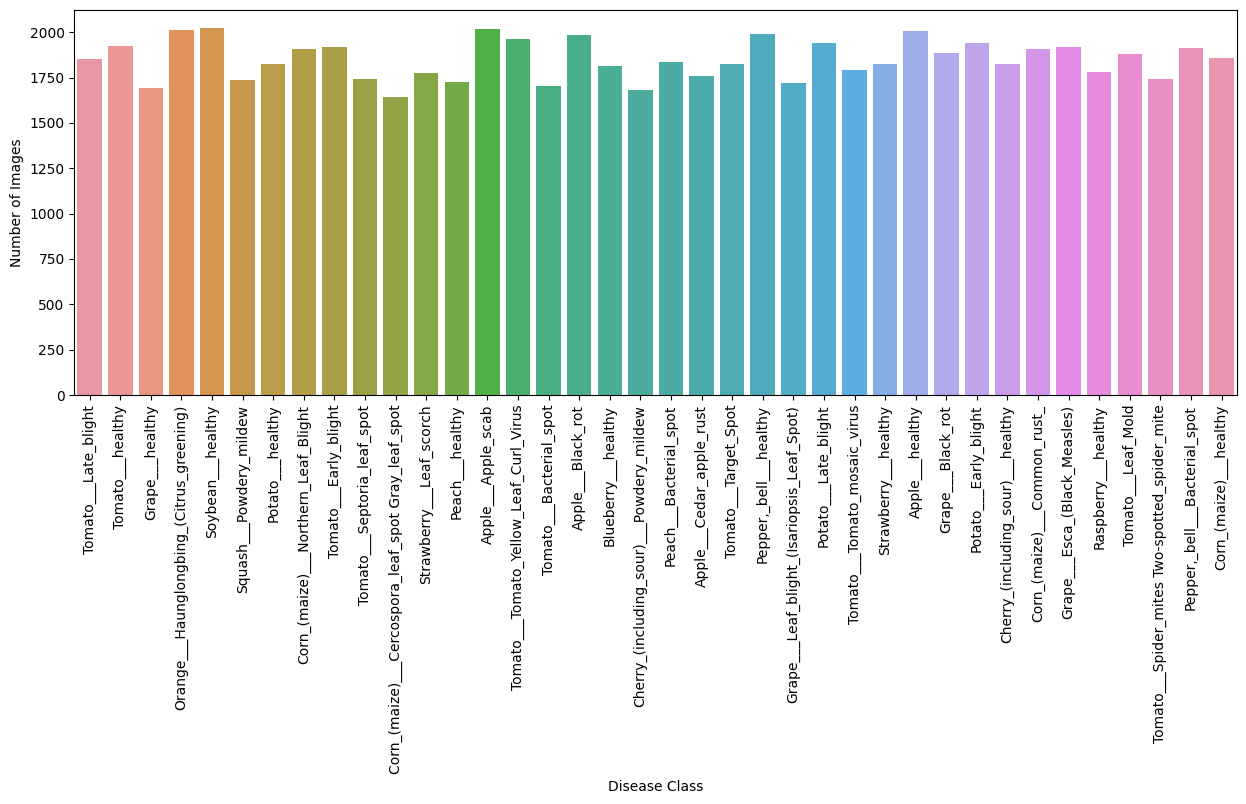

In [43]:
# show number of each class
dic = {}
for Class in diseases:
    dic[Class] = len(os.listdir(train_dir + '/' + Class))

df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

plt.figure(figsize=(15,5))
sns.barplot(data=df ,x='Disease Class' ,y= 'Number of Images' )
plt.xticks(rotation=90)
plt.show()

#### As we notice that classes are somewhat balanced

#### Display random samples from data

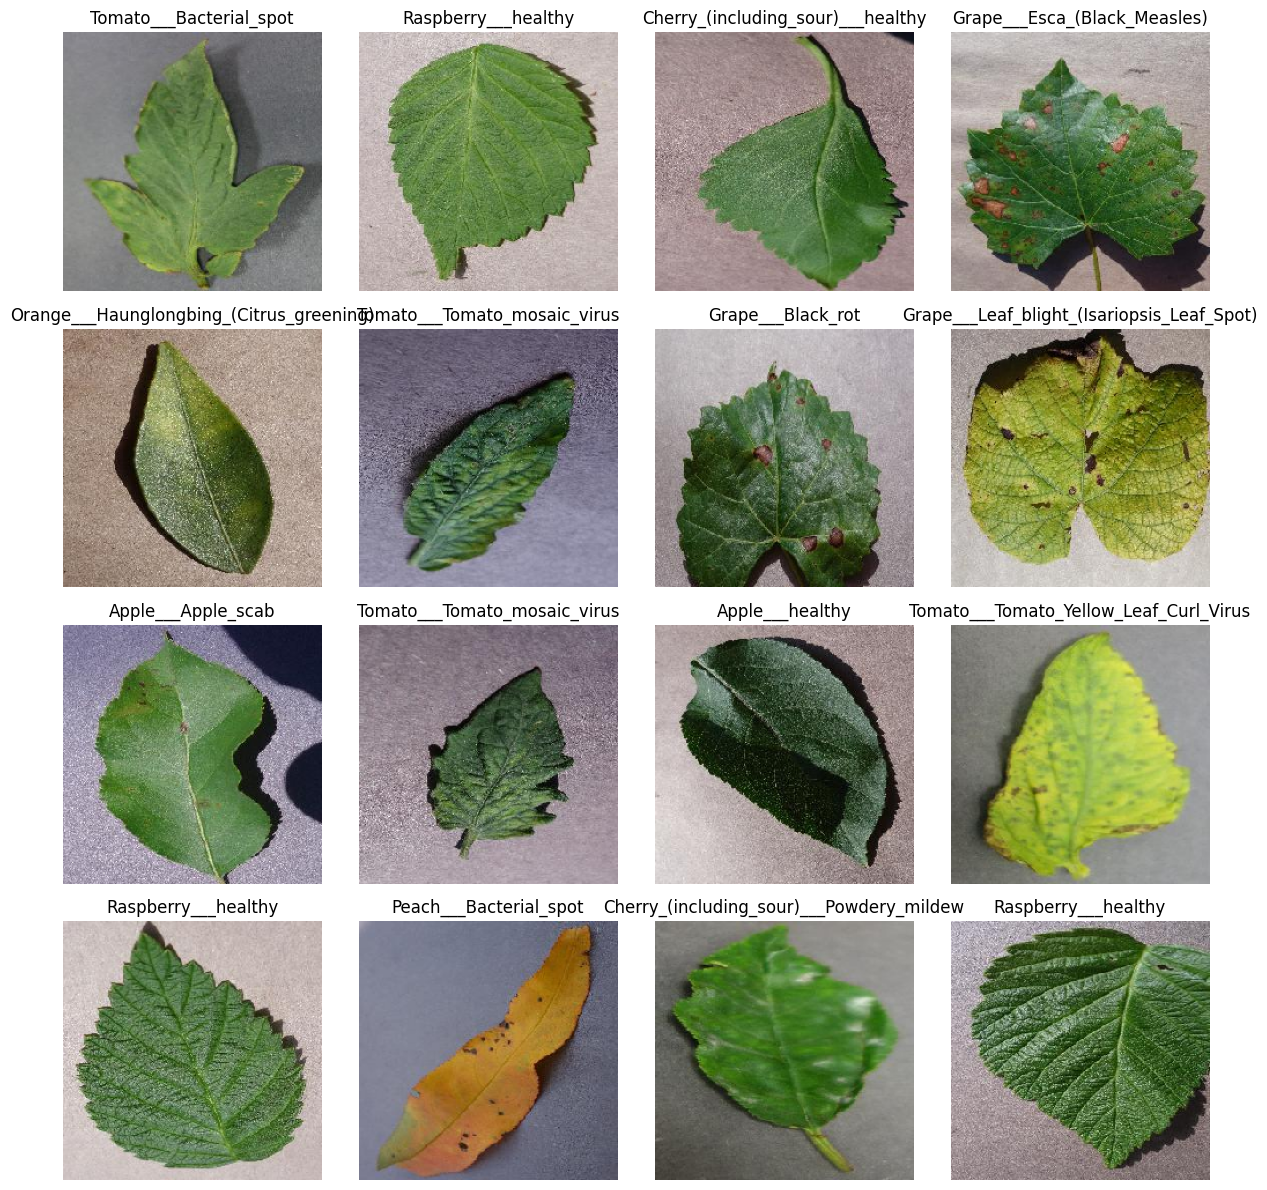

In [44]:
import random
# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])  
    plt.axis("off")  

plt.tight_layout()
plt.show()

## CNN Model

In [45]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'elu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

## Train the model


In [46]:
model_checkpoint = ModelCheckpoint('/kaggle/working/green_defend_cnn.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

In [47]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=30,
                    batch_size=64, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/30
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3536 - loss: 2.3090
Epoch 1: val_accuracy improved from -inf to 0.67438, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 261s 286ms/step - accuracy: 0.3537 - loss: 2.3083 - val_accuracy: 0.6744 - val_loss: 1.0345
Epoch 2/30
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7406 - loss: 0.8469
Epoch 2: val_accuracy improved from 0.67438 to 0.76260, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 244s 276ms/step - accuracy: 0.7407 - loss: 0.8468 - val_accuracy: 0.7626 - val_loss: 0.7408
Epoch 3/30
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8593 - loss: 0.4507
Epoch 3: val_accuracy improved from 0.76260 to 0.87902, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 244s 276ms/step - accuracy: 0.8593 - loss: 0.4506 - val_accuracy: 0.8790 - val_loss: 0.3656
Epoch 4/30
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 

***Function will be used***
##### Learning curve function
> * learning curve
> * loss curve

In [48]:
def plot_learning_curves(history, save_path=None, color_scheme=('blue', 'orange')):
    plt.figure(figsize=(14, 5))

    # Automatically determine the best epoch based on validation accuracy
    best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], color=color_scheme[0], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], color=color_scheme[1], linestyle='--', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim(0, best_epoch)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], color=color_scheme[0], label='Training Loss')
    plt.plot(history.history['val_loss'], color=color_scheme[1], linestyle='--', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(0, best_epoch)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f'Plot saved as {save_path}')

    plt.show()

### Display accuracy and loss curves for model history 

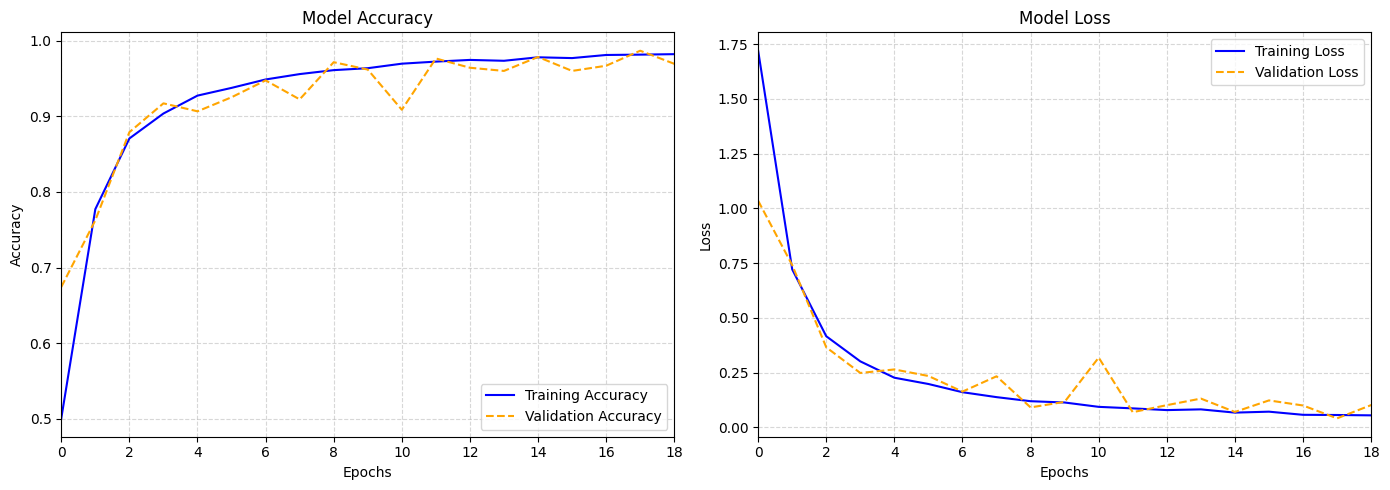

In [49]:
plot_learning_curves(history)

In [50]:
# save model to use later
model.save('/kaggle/working/green_defend_cnn.keras')

In [51]:
# showe accuracy on test data (model evaluation)
best_model = load_model('/kaggle/working/green_defend_cnn.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 61s 219ms/step - accuracy: 0.9914 - loss: 0.0270
Test Loss: 0.0349
Test Accuracy: 0.9891


#### Prediction function
> Compare Truth label (name of image ) with predicted label

In [52]:
def predict_labels_and_display(model_path, test_dir=test_dir, image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): 
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### show random sample of prediction of model on test data

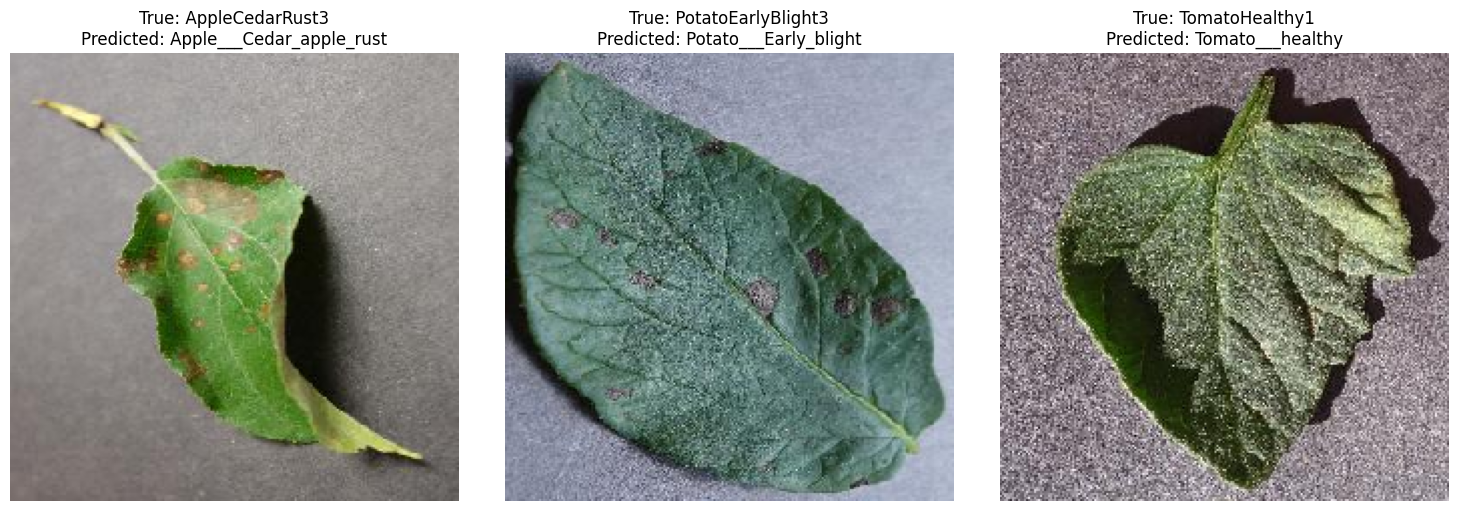

In [53]:
predict_labels_and_display('/kaggle/working/green_defend_cnn.keras')

## Evaluate model performance

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

def evaluate_model(model_path, test_data, model_name):
    # load model
    model = tf.keras.models.load_model(model_path)

    # predict
    y_pred = model.predict(test_data)
    y_pred_classes = y_pred.argmax(axis=1)

    # get true classes
    y_true = test_data.classes

    class_labels = list(test_data.class_indices.keys())

    accuracy = accuracy_score(y_true, y_pred_classes)

    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

    df_report = pd.DataFrame(report).transpose()

    df_report.loc['accuracy'] = [accuracy, None, None, None]

    df_report['model'] = model_name

    return df_report

cnn_model_path = 'green_defend_cnn.keras'

cnn_report = evaluate_model(cnn_model_path, test_data, 'CNN')

all_reports = pd.concat([cnn_report])

all_reports = all_reports.reset_index().rename(columns={'index': 'metric'})

all_reports

275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 173ms/step


metric  precision    recall  \
0                                  Apple___Apple_scab   0.994071  0.998016   
1                                   Apple___Black_rot   0.997988  0.997988   
2                            Apple___Cedar_apple_rust   0.995475  1.000000   
3                                     Apple___healthy   0.997992  0.990040   
4                                 Blueberry___healthy   0.991228  0.995595   
5            Cherry_(including_sour)___Powdery_mildew   1.000000  0.990499   
6                   Cherry_(including_sour)___healthy   0.993450  0.997807   
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   0.960396  0.946341   
8                         Corn_(maize)___Common_rust_   0.997904  0.997904   
9                 Corn_(maize)___Northern_Leaf_Blight   0.950719  0.970650   
10                             Corn_(maize)___healthy   0.997854  1.000000   
11                                  Grape___Black_rot   0.997845  0.980932   
12                       Grape___Esca_(Black_Measles)   0.981595  1.000000   
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   0.995272  0.979070   
14                                    Grape___healthy   0.992941  0.997636   
15           Orange___Haunglongbing_(Citrus_greening)   0.992063  0.994036   
16                             Peach___Bacterial_spot   0.997807  0.991285   
17                                    Peach___healthy   0.997685  0.997685   
18                      Pepper,_bell___Bacterial_spot   1.000000  1.000000   
19                             Pepper,_bell___healthy   0.974155  0.985915   
20                              Potato___Early_blight   1.000000  1.000000   
21                               Potato___Late_blight   0.989583  0.979381   
22                                   Potato___healthy   0.993348  0.982456   
23                                Raspberry___healthy   0.984410  0.993258   
24                                  Soybean___healthy   0.980545  0.998020   
25                            Squash___Powdery_mildew   1.000000  1.000000   
26                           Strawberry___Leaf_scorch   0.982183  0.993243   
27                               Strawberry___healthy   0.997812  1.000000   
28                            Tomato___Bacterial_spot   0.995204  0.976471   
29                              Tomato___Early_blight   0.989362  0.968750   
30                               Tomato___Late_blight   0.982262  0.956803   
31                                 Tomato___Leaf_Mold   0.997859  0.991489   
32                        Tomato___Septoria_leaf_spot   0.977578  1.000000   
33      Tomato___Spider_mites Two-spotted_spider_mite   0.995169  0.947126   
34                               Tomato___Target_Spot   0.939709  0.989059   
35             Tomato___Tomato_Yellow_Leaf_Curl_Virus   0.991870  0.995918   
36                       Tomato___Tomato_mosaic_virus   0.993333  0.997768   
37                                   Tomato___healthy   0.991718  0.995842   
38                                           accuracy   0.989074       NaN   
39                                          macro avg   0.989168  0.988868   
40                                       weighted avg   0.989192  0.989074   

    f1-score  support model  
0   0.996040    504.0   CNN  
1   0.997988    497.0   CNN  
2   0.997732    440.0   CNN  
3   0.994000    502.0   CNN  
4   0.993407    454.0   CNN  
5   0.995227    421.0   CNN  
6   0.995624    456.0   CNN  
7   0.953317    410.0   CNN  
8   0.997904    477.0   CNN  
9   0.960581    477.0   CNN  
10  0.998926    465.0   CNN  
11  0.989316    472.0   CNN  
12  0.990712    480.0   CNN  
13  0.987104    430.0   CNN  
14  0.995283    423.0   CNN  
15  0.993049    503.0   CNN  
16  0.994536    459.0   CNN  
17  0.997685    432.0   CNN  
18  1.000000    478.0   CNN  
19  0.980000    497.0   CNN  
20  1.000000    485.0   CNN  
21  0.984456    485.0   CNN  
22  0.987872    456.0   CNN  
23  0.988814    445.0   CNN  
24  0.989205    505.

In [55]:
final_report =all_reports[all_reports['metric'] == 'macro avg']
final_report

metric  precision    recall  f1-score  support model
39  macro avg   0.989168  0.988868  0.988954  17572.0   CNN

## Convert Model to TFLite file

**It will be better if you do this step in colab platform**

In [56]:
# import os
# print(os.listdir("/kaggle/working"))

In [57]:
# import tensorflow as tf

# # Load the model
# model = tf.keras.models.load_model('green_defend_cnn.keras')

# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model
# with open('green_defend_cnn.tflite', 'wb') as f:
#     f.write(tflite_model)